# PN2V Prediction
Please run the 'Convallaria-1-CreateNoiseModel' and 'Convallaria-2-Training' notebooks first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='data/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network and Noise Model

In [3]:
# We are loading the histogram from the 'Convallaria-1-CreateNoiseModel' notebook.
histogram=np.load(path+'noiseModel.npy')

# Create a NoiseModel object from the histogram.
noiseModel=histNoiseModel.NoiseModel(histogram, device=device)

In [4]:
# Load the network, created in the 'Convallaria-2-Training' notebook
net=torch.load(path+"/last_conv.net")

### Evaluation

image: 0
PSNR input 29.009240856174337
PSNR prior 35.292740574106304
PSNR mse 36.064934421514494
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR prior 35.244341105768655
PSNR mse 35.99956409390551
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR prior 35.30096550740709
PSNR mse 36.061814602426374
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR prior 35.45835513148096
PSNR mse 36.254773782642296
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR prior 35.48158683859872
PSNR mse 36.28827619363447
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR prior 35.43721038672964
PSNR mse 36.19226069876489
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR prior 35.38281343692522
PSNR mse 36.17684526719399
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR prior 35.31588949097545
PSNR mse 36

image: 63
PSNR input 28.943605925782467
PSNR prior 35.38911957328581
PSNR mse 36.12381265510169
-----------------------------------
image: 64
PSNR input 28.984797176949073
PSNR prior 35.442563195752015
PSNR mse 36.21512381750427
-----------------------------------
image: 65
PSNR input 28.994764258029022
PSNR prior 35.48930586618433
PSNR mse 36.29725858616978
-----------------------------------
image: 66
PSNR input 28.974272339535343
PSNR prior 35.358254477007996
PSNR mse 36.08567043041967
-----------------------------------
image: 67
PSNR input 28.968391660007423
PSNR prior 35.475517611108685
PSNR mse 36.234067672867944
-----------------------------------
image: 68
PSNR input 28.930129735581886
PSNR prior 35.334496118785424
PSNR mse 36.10051954190696
-----------------------------------
image: 69
PSNR input 28.97258922282324
PSNR prior 35.450595957887835
PSNR mse 36.237970250838764
-----------------------------------
image: 70
PSNR input 28.917087395242863
PSNR prior 35.4489260181518
PS

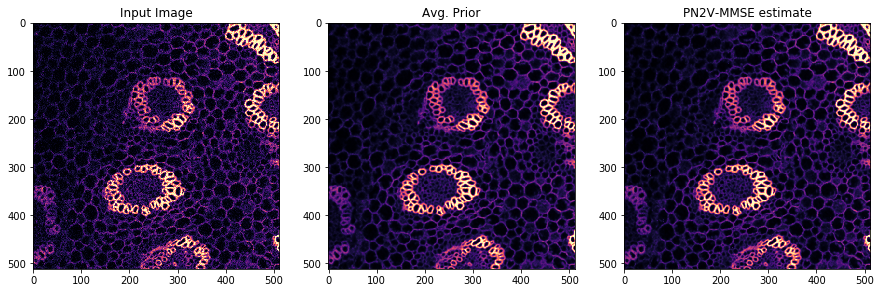

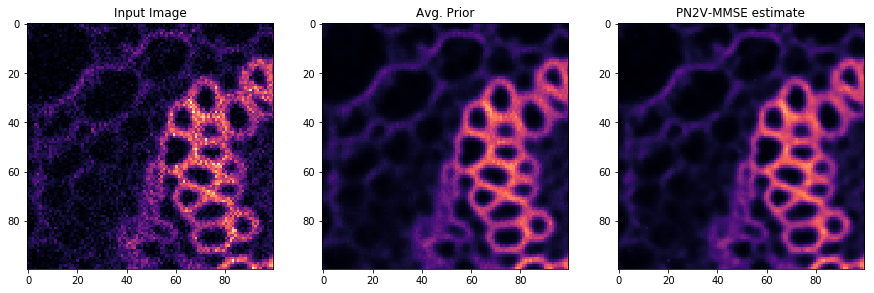

Avg PSNR Prior: 35.4189173321067 +-(2SEM) 0.01865909042375839
Avg PSNR MMSE: 36.188104991257234 +-(2SEM) 0.02096664405069142


In [5]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=noiseModel)
    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, mseEst,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )